In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import shutil
from torchvision import datasets
from torchvision.io import read_image
import pandas as pd
import matplotlib.pyplot as plt
import math

c:\Users\frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_heigt = 144
image_width = 192
rgb = 3

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #3 input image channel, 6 output channels, 5x5 square convolution with 0 padding
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*33*45, 256),
            nn.ReLU(),
            nn.Linear(256, 30),
            nn.ReLU(),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        logits = self.conv1(x)
        logits = self.relu(logits)
        logits = self.pool(logits)
        logits = self.conv2(logits)
        logits = self.relu2(logits)
        logits = self.pool2(logits)
        logits = self.dropout(logits)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

Using cuda device
ConvNeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=23760, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=30, bias=True)
    (3): ReLU()
    (4): LogSoftmax(dim=1)
  )
)


In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)
    


In [5]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss
    

In [3]:
#load data
dataset = datasets.ImageFolder(root = 'material_im_non_plu/', transform = Compose([
    transforms.ToTensor(),
]))

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
print(len(train_dataset))
print(len(test_dataset))

7296
1824


In [9]:
#load data into dataloader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
image = next(iter(train_dataloader))[0][0]

In [11]:
image.shape

torch.Size([3, 144, 192])

In [12]:
#model parameters
learning_rate = 1e-3
epochs = 100
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
#train model
early_stopping = EarlyStopper()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if early_stopping.early_stop(test_loss):
        print("Early stopping")
        break
print("Done!")


Epoch 1
-------------------------------
loss: 3.371233  [    0/ 7296]
loss: 3.098129  [ 6400/ 7296]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.997076 

Epoch 2
-------------------------------
loss: 2.977863  [    0/ 7296]
loss: 2.741866  [ 6400/ 7296]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.694663 

Epoch 3
-------------------------------
loss: 2.636820  [    0/ 7296]
loss: 2.690850  [ 6400/ 7296]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.623730 

Epoch 4
-------------------------------
loss: 2.548631  [    0/ 7296]
loss: 2.670380  [ 6400/ 7296]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.589683 

Epoch 5
-------------------------------
loss: 2.502090  [    0/ 7296]
loss: 2.656379  [ 6400/ 7296]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.570151 

Epoch 6
-------------------------------
loss: 2.475782  [    0/ 7296]
loss: 2.644905  [ 6400/ 7296]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.556730 

Epoch 7
-------------------------------
loss: 2.457016  [    0/ 7296]
loss: 2.635405  [ 

In [17]:
material_encoding = ['cloth',
 'metal',
 'fruit',
 'candle',
 'wood',
 'pottery',
 'shell',
 'plastic',
 'stone',
 'glass',
 'paper',
 'vegetable',
 'iron',
 'cane',
 'sponge',
 'rope',
 'foam',
 'rubber',
 'cotton',
 'velvet',
 'flower',
 'copper',
 'food',
 '',
 'wool',
 'wire',
 'elastic',
 'herbs',
 'plant',
 'feathers']

In [18]:
#predict 
def predict_image(img, model):
    # Convert to a batch of 1
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(img)
        return pred

In [19]:
def material_encoding_to_string(binary_str):
    for index, char in enumerate(str(binary_str)):
        if char == '1':
            return material_encoding[index]
    return "no encoding found"

In [20]:
train_dataset.dataset.class_to_idx

{'000000000000000000000000000001': 0,
 '000000000000000000000000010000': 1,
 '000000000000000000000001000000': 2,
 '000000000000000000000010000000': 3,
 '000000000000000000000100000000': 4,
 '000000000000000000001000000000': 5,
 '000000000000000000100000000000': 6,
 '000000000000000001000000000000': 7,
 '000000000000000010000000000000': 8,
 '000000000000000100000000000000': 9,
 '000000000000001000000000000000': 10,
 '000000000000010000000000000000': 11,
 '000000000001000000000000000000': 12,
 '000000000010000000000000000000': 13,
 '000000000100000000000000000000': 14,
 '000000001000000000000000000000': 15,
 '000000010000000000000000000000': 16,
 '000000100000000000000000000000': 17,
 '000001000000000000000000000000': 18,
 '000010000000000000000000000000': 19,
 '000100000000000000000000000000': 20,
 '001000000000000000000000000000': 21,
 '010000000000000000000000000000': 22,
 '100000000000000000000000000000': 23}

In [21]:
def index_to_class(index):
    classes = train_dataset.dataset.class_to_idx
    for key, value in classes.items():
        if value == index:
            return key

In [22]:
result = predict_image(test_dataset[50][0], model)
actual = test_dataset[50][1]
print(f"Predicted class: {index_to_class(result.argmax(1).item())}, Actual class: {index_to_class(actual)}")
print(f"Predicted material: {material_encoding_to_string(index_to_class(result.argmax(1).item()))}, Actual material: {material_encoding_to_string(index_to_class(actual))}")

Predicted class: 000001000000000000000000000000, Actual class: 000001000000000000000000000000
Predicted material: pottery, Actual material: pottery


In [23]:
#probability of each material
result = predict_image(test_dataset[1][0], model)
sum = 0
for index, probability in enumerate(result[0]):
    #mark the highest probability
    if index == result.argmax(1).item():
        print(f"{material_encoding_to_string(index_to_class(index))}: {math.exp(probability.item()) * 100}%, <---")
    else:
        print("index:" + str(index))
        print(f"{material_encoding_to_string(index_to_class(index))}: {math.exp(probability.item()) * 100}%")
    sum += math.exp(probability.item())

index:0
feathers: 0.016372094323612335%
index:1
wire: 0.016372094323612335%
index:2
: 0.016372094323612335%
index:3
food: 0.016372094323612335%
index:4
copper: 0.016372094323612335%
index:5
flower: 0.016372094323612335%
index:6
cotton: 0.016372094323612335%
index:7
rubber: 0.128920573189703%
index:8
foam: 0.02575701802372599%
index:9
rope: 0.016372094323612335%
index:10
sponge: 0.016372094323612335%
index:11
cane: 0.016372094323612335%
index:12
vegetable: 0.016372094323612335%
index:13
paper: 0.016372094323612335%
index:14
glass: 0.016372094323612335%
index:15
stone: 0.027213214196820868%
index:16
plastic: 0.22074722590867824%
index:17
shell: 0.016372094323612335%
index:18
pottery: 0.016372094323612335%
index:19
wood: 0.016372094323612335%
index:20
candle: 0.016372094323612335%
index:21
fruit: 0.016372094323612335%
index:22
metal: 1.0160722074392348%
cloth: 98.18835259164503%, <---
index:24
no encoding found: 0.016372094323612335%
index:25
no encoding found: 0.016372094323612335%
index

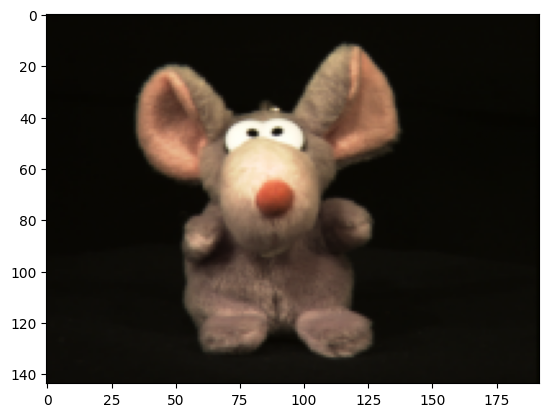

In [24]:
#print image
plt.imshow(test_dataset[1][0].permute(1, 2, 0))
plt.show()

In [25]:
#save model
torch.save(model.state_dict(), "model_convol.pth")

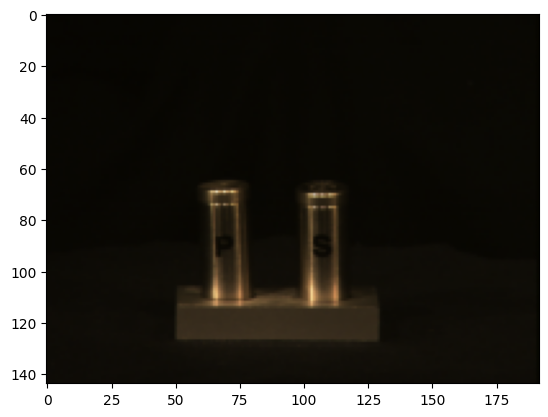

In [26]:
path = "aloi_red4_col/png4/56/56_i120.png"
img = plt.imread(path)[:,:,:3]
plt.imshow(img)


In [27]:
result = predict_image(ToTensor()(img), model)

In [28]:
for index, probability in enumerate(result[0]):
    #mark the highest probability
    if index == result.argmax(1).item():
        print(f"{material_encoding_to_string(index_to_class(index))}: {math.exp(probability.item()) * 100}%, <---")
    else:
        print("index:" + str(index))
        print(f"{material_encoding_to_string(index_to_class(index))}: {math.exp(probability.item()) * 100}%")

index:0
feathers: 0.8020502801223991%
index:1
wire: 0.8020502801223991%
index:2
: 1.7348920943934285%
index:3
food: 0.8020502801223991%
index:4
copper: 0.8020502801223991%
index:5
flower: 0.8020502801223991%
index:6
cotton: 0.8020502801223991%
index:7
rubber: 1.9956173062428602%
index:8
foam: 0.8020502801223991%
index:9
rope: 0.8020502801223991%
index:10
sponge: 0.8020502801223991%
index:11
cane: 0.8020502801223991%
index:12
vegetable: 2.6773249851704506%
index:13
paper: 14.171462668624088%
index:14
glass: 4.453073725206004%
index:15
stone: 4.548830208285781%
index:16
plastic: 15.19961381209163%
index:17
shell: 0.8020502801223991%
index:18
pottery: 2.6086713266963777%
index:19
wood: 7.701116521228238%
index:20
candle: 0.8020502801223991%
index:21
fruit: 0.8020502801223991%
metal: 28.704213321023193%, <---
index:23
cloth: 0.9662291342785222%
index:24
no encoding found: 0.8020502801223991%
index:25
no encoding found: 0.8020502801223991%
index:26
no encoding found: 0.8020502801223991%
ind

In [29]:
input = torch.randn(3, 144, 192)
conv1 = nn.Conv2d(3, 6, 5)
relu = nn.ReLU()
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
pool2 = nn.MaxPool2d(2, 2)

In [30]:
in1 = conv1(input)
in2 = relu(in1)
in3 = pool(in2)
in4 = conv2(in3)
in5 = pool2(in4)

In [31]:
in5.shape

torch.Size([16, 33, 45])

In [32]:
#save model
torch.save(model.state_dict(), "model_convol.pth")